# Set Contribution Functions Application Example
In this notebook, we sketch an application scenario illustrating how set contribution functions can be applied.
The scenario helps us highlight differences between single-argument and set contribution functions, as well as the relevance of some of the differences between set contribution functions that *principles* give rise to.
The application is based on [work by Sukpanichnant, Rapberger, and Toni](https://arxiv.org/pdf/2409.16813?), which incorporates Natural Language Processing (NLP) techniques into QBAF-based classification.
We apply our approach to an example QBAF reflecting one that has been reported in the above work.
However, the approach is applicable to generic scenarios and the paper links to open-source code that can be used for QBAF instantiation from data (in contrast, we manually specify the initial QBAF for the sake of simplicity).
We provide a walk-through of the code, while in parallel explaining the use case.

First, we install and import the dependencies.

In [2]:
%%capture
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install 'QBAF-Py[Visualizer] @ git+https://github.com/TimKam/Quantitative-Bipolar-Argumentation'

In [3]:
from qbaf import QBAFramework
from qbaf_visualizer.Visualizer import visualize

from qbaf_ctrbs.removal import determine_removal_ctrb
from qbaf_ctrbs.intrinsic_removal import determine_iremoval_ctrb
from qbaf_ctrbs.shapley import determine_shapley_ctrb
from qbaf_ctrbs.gradient import determine_gradient_ctrb

We apply set contribution functions to a QBAF representing reviews and gradual acceptance/rejection recommendations for scientific papers.

**Note.** The use-case is purely illustrative and we do **not** recommend an immediate application to the scenario at hand, which requires more comprehensive evaluations and a careful consideration of social/human aspects.


Consider the QBAF below.
We have a three-layered QBAF. The topic argument on the "bottom" layer represents the review recommendation, which can be discretized, i.e. (roughly), mapped to recommendations from *strong reject* to *strong accept*.
Its initial strength is $0.5$ (which would reflect a *borderline* evaluation if interpreted as a final strength).
The layer above represents *aspects* that the review may cover, which are provided as a generic meta-model for this use-case:
*appropriateness*, *clarity*, *novelty*, *empirical and
theoretical soundness*, *meaningful comparison*, *substance*, and *impact*, appreviated as `APR`, `CLA`, `NOV`, `EMP`, `CMP`, `SUB`, and `IMP`, respectively. These arguments are also initiated with a strength of $0.5$ each.
Finally, layer three represents three text arguments representing sentences and their sentiment strength, which, including final strengths and alongside the support and attack relationships to the *aspect* layer, are mined--in the aforementioned paper--using NLP approaches.
Each aspect argument attacks or supports the decision argument, depending on whether its final strength is above or below $0.5$ (respectively).
This means we first compute the final strengths of the aspects arguments before determining their relationships with the decision argument.
Also, before the computation of the decision argument's final strength, the final strengths of the aspect arguments are normalized to a strength value in $(0 , 1]$ based on the distance to the initial value of $0.5$.
Strengths are updated using DF-QuAD semantics.

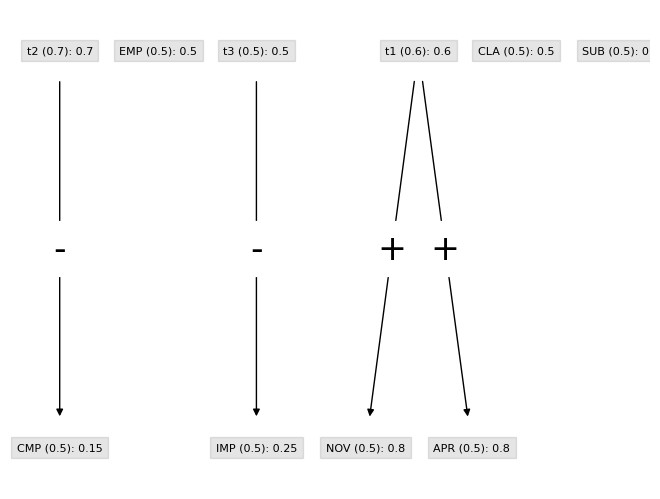

In [3]:
args = ['t1', 't2', 't3', 'APR', 'CLA', 'NOV', 'EMP', 'CMP', 'SUB', 'IMP']
initial_strengths = [0.6, 0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
atts = [('t2', 'CMP'), ('t3', 'IMP')]
supps = [('t1', 'APR'), ('t1', ('NOV'))]
qbaf_pre = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_pre, with_fs=True, round_to=6)

As the computation process is broken down into two steps that, when combined, do not correspond to the application of a gradual semantics to a QBAG, we focus on the contribution quantification within the second step, i.e., determining the contribution of aspect arguments to the decision.
For the combined approach, we could practically still apply the contribution functions, but the application would break the frame of our analytical results with respect to principle satisfaction.

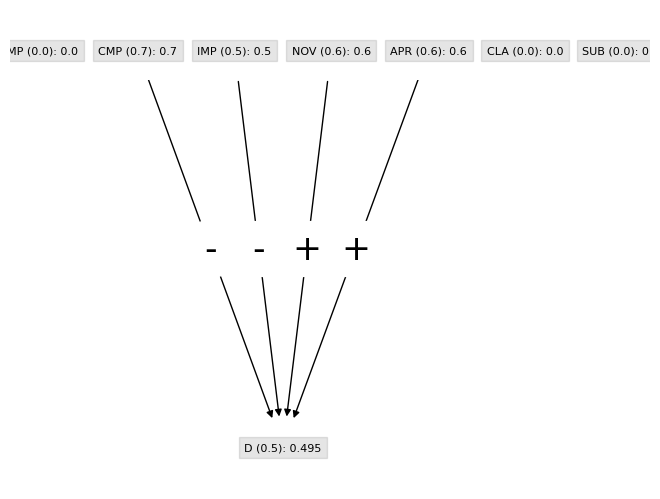

In [5]:
args = ['APR', 'CLA', 'NOV', 'EMP', 'CMP', 'SUB', 'IMP']
pre_initial_strengths = [qbaf_pre.final_strengths[x] for x in args]
initial_strengths = [2 * abs(x - 0.5) for x in pre_initial_strengths] + [0.5]
atts = [(x, 'D') for x in args if pre_initial_strengths[args.index(x)] < 0.5]
supps = [(x, 'D') for x in args if pre_initial_strengths[args.index(x)] > 0.5 ]
qbaf = QBAFramework(args + ['D'], initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

Below, we compute and print different set contributions of the set `{ NOV, IMP }` on the topic, as well as the single-argument contributions of `NOV` and `IMP` (separated) and their sum. We can also see that the contributions distributed to the players `{ NOV, IMP }`, `CMP`, and `APR` by the Shapley value account exactly for the difference between our topic argument's final and initial strengths, as expected.

In [11]:
# Remove
r_ctrb_nov_imp_to_d = determine_removal_ctrb('D', {'NOV', 'IMP'}, qbaf)
r_ctrb_nov_to_d = determine_removal_ctrb('D', {'NOV'}, qbaf)
r_ctrb_imp_to_d = determine_removal_ctrb('D', {'IMP'}, qbaf)
r_ctrb_cmp_to_d = determine_removal_ctrb('D', {'CMP'}, qbaf)
r_ctrb_apr_to_d = determine_removal_ctrb('D', {'APR'}, qbaf)
print('Contribution { NOV, IMP } to D, removal:', r_ctrb_nov_imp_to_d)
print('Contribution NOV to D, removal:', r_ctrb_nov_to_d)
print('Contribution IMP to D, removal:', r_ctrb_imp_to_d)
print('Contribution CMP to D, removal:', r_ctrb_cmp_to_d)
print('Contribution APR to D, removal:', r_ctrb_apr_to_d)
print('Contributions CMP  + APR + {NOV, IMP} to D, removal:', r_ctrb_cmp_to_d + r_ctrb_apr_to_d + r_ctrb_nov_imp_to_d)
print('\n\n')

# Shapley
s_ctrb_nov_imp_to_d = determine_shapley_ctrb('D', {'NOV', 'IMP'}, qbaf)
s_ctrb_nov_to_d = determine_shapley_ctrb('D', {'NOV'}, qbaf)
s_ctrb_imp_to_d = determine_shapley_ctrb('D', {'IMP'}, qbaf)
s_ctrb_cmp_to_d = determine_shapley_ctrb('D', {'CMP'}, qbaf)
s_ctrb_apr_to_d = determine_shapley_ctrb('D', {'APR'}, qbaf)
print('Contribution { NOV, IMP } to D, shapley:', s_ctrb_nov_imp_to_d)
print('Contribution NOV to D, shapley:', s_ctrb_nov_to_d)
print('Contribution IMP to D, shapley:', s_ctrb_imp_to_d)
print('Contribution CMP to D, shapley:', s_ctrb_cmp_to_d)
print('Contribution APR to D, shapley:', s_ctrb_apr_to_d)
print('Contributions CMP  + APR + {NOV, IMP} to D, shapley:', s_ctrb_cmp_to_d + s_ctrb_apr_to_d + s_ctrb_nov_imp_to_d)
print('\n\n')

# Gradient
g_ctrb_nov_imp_to_d = determine_gradient_ctrb('D', {'NOV', 'IMP'}, qbaf)
g_ctrb_nov_to_d = determine_gradient_ctrb('D', {'NOV'}, qbaf)
g_ctrb_imp_to_d = determine_gradient_ctrb('D', {'IMP'}, qbaf)
g_ctrb_cmp_to_d = determine_gradient_ctrb('D', {'CMP'}, qbaf)
g_ctrb_apr_to_d = determine_gradient_ctrb('D', {'APR'}, qbaf)
print('Contribution { NOV, IMP } to D, gradient (max):', g_ctrb_nov_imp_to_d)
print('Contribution NOV to D, gradient:', g_ctrb_nov_to_d)
print('Contribution IMP to D, gradient:', g_ctrb_imp_to_d)
print('Contribution CMP to D, gradient:', g_ctrb_cmp_to_d)
print('Contribution APR to D, gradient:', g_ctrb_apr_to_d)
print('Contributions CMP  + APR + {NOV, IMP} to D, removal:', g_ctrb_cmp_to_d + g_ctrb_apr_to_d + g_ctrb_nov_imp_to_d)

Contribution { NOV, IMP } to D, removal: 0.044999999999999984
Contribution NOV to D, removal: 0.12
Contribution IMP to D, removal: -0.07500000000000001
Contribution CMP to D, removal: -0.175
Contribution APR to D, removal: 0.12
Contributions CMP  + APR + {NOV, IMP} to D, removal: -0.010000000000000009



Contribution { NOV, IMP } to D, shapley: 0.047500000000000014
Contribution NOV to D, shapley: 0.21000000000000002
Contribution IMP to D, shapley: -0.1625
Contribution CMP to D, shapley: -0.26249999999999996
Contribution APR to D, shapley: 0.21000000000000002
Contributions CMP  + APR + {NOV, IMP} to D, shapley: -0.004999999999999921



Contribution { NOV, IMP } to D, gradient (max): 0.19999999925494194
Contribution NOV to D, gradient: 0.19999999925494194
Contribution IMP to D, gradient: -0.15000000223517418
Contribution CMP to D, gradient: -0.25
Contribution APR to D, gradient: 0.19999999925494194
Contributions CMP  + APR + {NOV, IMP} to D, removal: 0.14999999850988388


Let us take a more detailed look at the results. From a use-case perspective, the idea is to focus on novelty and impact, as their assessment may be rather subjective.
We drop the *intrinsic removal*-based set contribution function here, as its contributions clearly coincide with the ones of the removal-based variant. Note that an application example where the difference between intrinsic removal and removal-based contributions matter is presented for the single-argument case in a [paper by Kampik et al](https://arxiv.org/abs/2401.08879). We do not cover it here for the sake of conciceness and rather use an example relating to a different application.
As we can see, set contributions differ meaningfully from the single argument contributions and their sum-based aggregations.
However, the gradient set contribution of `{ NOV, IMP }` on the topic equals to the single-argument contribution of $~0.2$ (as expected).
Overall, these results indicate that there is a meaningful difference between set contribution and single-argument contribution functions.

Between set contribution functions, we see different purposes and effects:

* The removal-based contribution of $0.045$ describes what would happen if we were to ignore novelty and impact assessment, reflecting the principle of strong counterfactuality: we can see that the absence of these aspects would decrease the final strengths of the topic argument accordingly. In our use-case this means that the paper, whose score corresponds to a somewhat *weak borderline* recommendation, would be further weakened in absence of these rather subjective aspects, which may help a meta-reviewer interpret the review as being more on the "reject side" of the scale.

* The Shapley-based contribution of $0.0475$ indicates how much novelity and impact assessments contribute, as a "group" to the overall score, relative to the contributions of the other aspects, which are grouped separately each. The soundness of the contribution is reflected by the weak quantitative contribution existence principle. However, if we want to compare the contribution relative to another set of several aspects, we would need to make use of the partition contribution function. In our example, Shapley-based contribution and removal-based contribution support the same narrative: the two somewhat opinionated aspects *novelty* and *impact* positively affect the score.

* The gradient-based contribution function (yielding a contribution of $~0.2$) quantifies the effectiveness of applying a change to the aspect among `{ NOV, IMP }` that has a locally greater effect. for this, we would expect behavior that amounts to monotonicity. For the opposite direction (how to best affect a lower score), we would need to use `min` as our aggregation function of the gradient.

* Finally, in this example, the three set contribution functions induce similar rankings over most contributors/sets, but they do not coincide in general. 
This is most visible for the set contributor `{ NOV, IMP }`, where the removal- and Shapley value-based approaches rank it third, while the gradient-max set contribution ranks it first.
The mismatch reflects that the gradient-based contribution function ranks sets by the \emph{locally strongest affect} inside the set, whereas removal- and Shapley value-based contributions measure the sets overall influence under counterfactual/game-theoretic conditions.
Consequently, adding further aspects to a set does not change impact measured by the gradient-based contribution function when their local effect does not exceed the current maximum, which can lead to different rankings compared to the other functions.

# Ranking Examples

The rankings induced by different set contribution functions are not guaranteed to align in general. Below, we give a few examples to make this more intuitive. 
The first example shows that the removal-based set contribution function is particularly sensitive to incoming attacks and support. 
The `Intrinsic Removal`, `Gradient`, and `Shapley` set contribution functions all produce the ranking `1. b, 2. c, 3. d`, while the `Removal` set contribution function produces `1. d, 2. c, 3. b`.
Intuitively, this happens because the incoming support relations flip the ranking.

--- Rankings ---

Removal
1. (d) Removal contribution: d to a -0.01763999999999999
2. (c) Removal contribution: c to a -0.019440000000000013
3. (b) Removal contribution: b to a -0.034440000000000026

Intrinsic Removal
1. (b) Intrinsic removal contribution: b to a -0.004200000000000037
2. (c) Intrinsic removal contribution: c to a -0.008100000000000052
3. (d) Intrinsic removal contribution: d to a -0.0126

Gradient
1. (b) Gradient contribution: b to a -0.008400000631809235
2. (c) Gradient contribution: c to a -0.01080000028014183
3. (d) Gradient contribution: d to a -0.015119999647140503

Shapley value
1. (b) Shapley contribution: b to a -0.0925616666666667
2. (c) Shapley contribution: c to a -0.11839500000000006
3. (d) Shapley contribution: d to a -0.15786166666666665


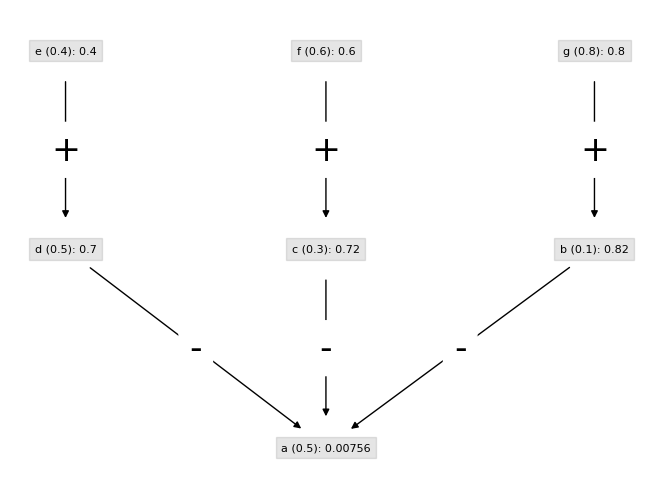

In [10]:
from qbaf_ctrbs.removal import determine_removal_ctrb
from qbaf_ctrbs.intrinsic_removal import determine_iremoval_ctrb
from qbaf_ctrbs.shapley import determine_shapley_ctrb
from qbaf_ctrbs.gradient import determine_gradient_ctrb

args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.5, 0.1, 0.3, 0.5, 0.4, 0.6, 0.8]
atts = [('b', 'a'), ('c', 'a'), ('d', 'a')]
supps = [('e', 'd'), ('f', 'c'), ('g', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

ctrb_gradient_b_to_a = determine_gradient_ctrb('a', {'b'}, qbaf)
ctrb_gradient_c_to_a = determine_gradient_ctrb('a', {'c'}, qbaf)
ctrb_gradient_d_to_a = determine_gradient_ctrb('a', {'d'}, qbaf)

ctrb_shapley_b_to_a = determine_shapley_ctrb('a', {'b'}, qbaf)
ctrb_shapley_c_to_a = determine_shapley_ctrb('a', {'c'}, qbaf)
ctrb_shapley_d_to_a = determine_shapley_ctrb('a', {'d'}, qbaf)

ctrb_iremoval_b_to_a = determine_iremoval_ctrb('a', {'b'}, qbaf)
ctrb_iremoval_c_to_a = determine_iremoval_ctrb('a', {'c'}, qbaf)
ctrb_iremoval_d_to_a = determine_iremoval_ctrb('a', {'d'}, qbaf)

ctrb_removal_b_to_a = determine_removal_ctrb('a', {'b'}, qbaf)
ctrb_removal_c_to_a = determine_removal_ctrb('a', {'c'}, qbaf)
ctrb_removal_d_to_a = determine_removal_ctrb('a', {'d'}, qbaf)

print("--- Rankings ---")
print()
print("Removal")
print('1. (d) Removal contribution: d to a', ctrb_removal_d_to_a)
print('2. (c) Removal contribution: c to a', ctrb_removal_c_to_a)
print('3. (b) Removal contribution: b to a', ctrb_removal_b_to_a)
print()
print("Intrinsic Removal")
print('1. (b) Intrinsic removal contribution: b to a', ctrb_iremoval_b_to_a)
print('2. (c) Intrinsic removal contribution: c to a', ctrb_iremoval_c_to_a)
print('3. (d) Intrinsic removal contribution: d to a', ctrb_iremoval_d_to_a)
print()
print("Gradient")
print('1. (b) Gradient contribution: b to a', ctrb_gradient_b_to_a)
print('2. (c) Gradient contribution: c to a', ctrb_gradient_c_to_a)
print('3. (d) Gradient contribution: d to a', ctrb_gradient_d_to_a)
print()
print("Shapley value")
print('1. (b) Shapley contribution: b to a', ctrb_shapley_b_to_a)
print('2. (c) Shapley contribution: c to a', ctrb_shapley_c_to_a)
print('3. (d) Shapley contribution: d to a', ctrb_shapley_d_to_a)


This discrepancy in ranking can be caused in some cases by the set contribution function, in others by the semantics, and sometimes by a mix of both. For example, below we show that with the `EulerBasedTop_model` semantics, the rankings from the removal-based and intrinsic removal-based approaches align (as opposed to the example above).

--- Rankings ---

Removal
1. (d) Removal contribution: d to a -0.02136528300312779
2. (c) Removal contribution: c to a 0.0
3. (b) Removal contribution: b to a 0.0

Intrinsic Removal
1. (d) Intrinsic removal contribution: d to a -0.012112538496682146
2. (b) Intrinsic removal contribution: b to a 0.0
3. (c) Intrinsic removal contribution: c to a 0.0


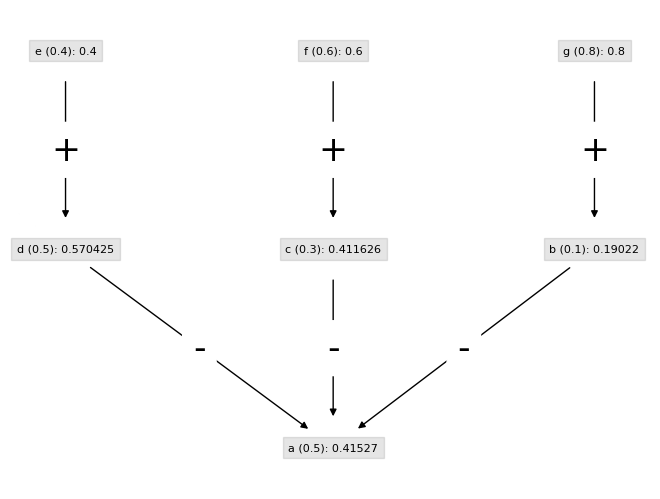

In [11]:
from qbaf_ctrbs.removal import determine_removal_ctrb
from qbaf_ctrbs.intrinsic_removal import determine_iremoval_ctrb

args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.5, 0.1, 0.3, 0.5, 0.4, 0.6, 0.8]
atts = [('b', 'a'), ('c', 'a'), ('d', 'a')]
supps = [('e', 'd'), ('f', 'c'), ('g', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf, with_fs=True, round_to=6)

ctrb_iremoval_b_to_a = determine_iremoval_ctrb('a', {'b'}, qbaf)
ctrb_iremoval_c_to_a = determine_iremoval_ctrb('a', {'c'}, qbaf)
ctrb_iremoval_d_to_a = determine_iremoval_ctrb('a', {'d'}, qbaf)

ctrb_removal_b_to_a = determine_removal_ctrb('a', {'b'}, qbaf)
ctrb_removal_c_to_a = determine_removal_ctrb('a', {'c'}, qbaf)
ctrb_removal_d_to_a = determine_removal_ctrb('a', {'d'}, qbaf)

print("--- Rankings ---")
print()
print("Removal")
print('1. (d) Removal contribution: d to a', ctrb_removal_d_to_a)
print('2. (c) Removal contribution: c to a', ctrb_removal_c_to_a)
print('3. (b) Removal contribution: b to a', ctrb_removal_b_to_a)
print()
print("Intrinsic Removal")
print('1. (d) Intrinsic removal contribution: d to a', ctrb_iremoval_d_to_a)
print('2. (b) Intrinsic removal contribution: b to a', ctrb_iremoval_b_to_a)
print('3. (c) Intrinsic removal contribution: c to a', ctrb_iremoval_c_to_a)